In [2]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [3]:
data = pd.read_excel("Данные.xlsx")
data = data.rename(columns={"дата": "date", "направление": "dir", "выход": "out"}).set_index("date")
data = data.iloc[::-1]
data.head()

,dir,out
date,,
2018-01-04,ш,67.67
2018-01-05,л,68.78
2018-01-09,ш,69.06
2018-01-10,ш,69.15
2018-01-11,л,69.86


In [4]:
result_df = pd.read_excel("Данные.xlsx", sheet_name=1, index_col=0)
result_df.head()

,направление,выход
дата,,
2022-01-03,NaN,NaN
2022-01-04,NaN,NaN
2022-01-05,NaN,NaN
2022-01-06,NaN,NaN
2022-01-07,NaN,NaN


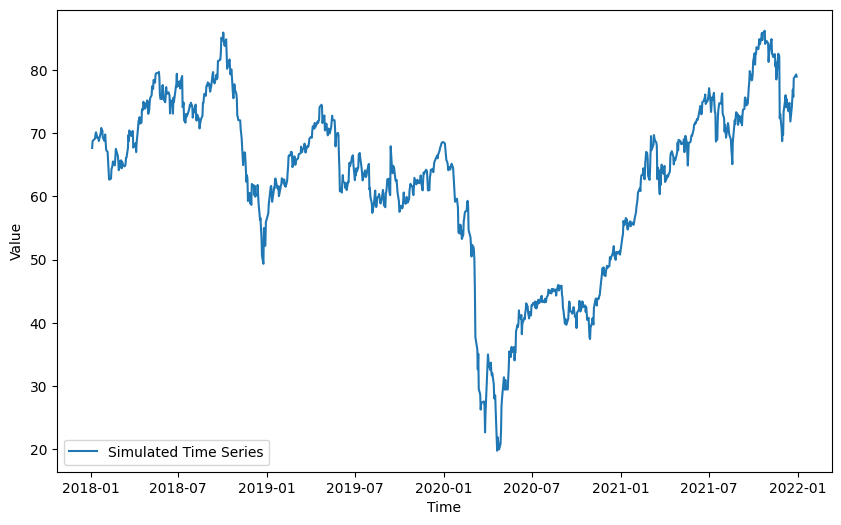

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["out"], label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [6]:
adfuller(data["out"], regression="ctt")

(-2.478181275068254,
 0.5818124192895627,
 0,
 1000,
 {'1%': -4.382754353047, '5%': -3.838308308284, '10%': -3.556924956559},
 3422.9409938842805)

Можно заметить, что это ряд типа DSP, который нужно остационаривать процедурой взятия разностей.

<Figure size 1000x600 with 0 Axes>

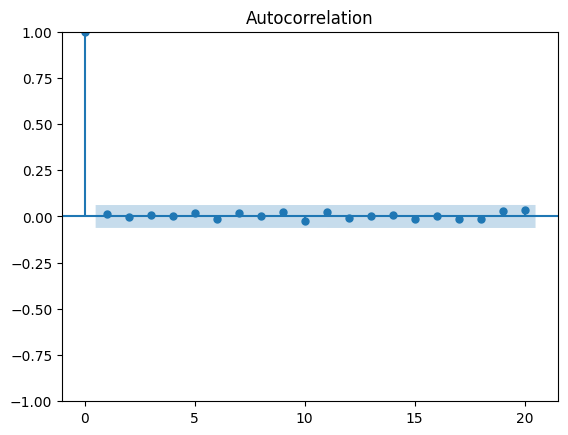

<Figure size 1000x600 with 0 Axes>

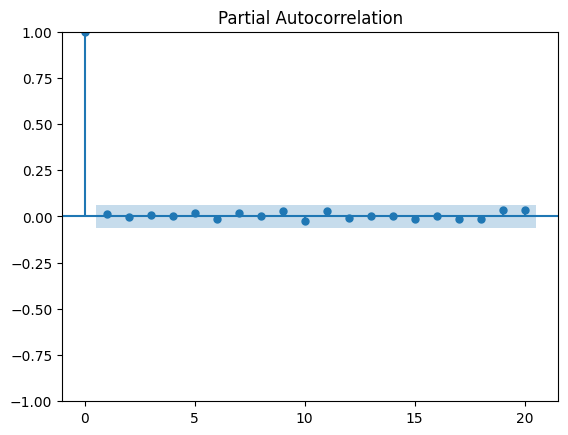

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(data.out.diff(1).dropna(), lags=20)
plt.show()

# Plot Partial Autocorrelation (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(data.out.diff(1).dropna(), lags=20, method='ywm')
plt.show()

Можно заметить, что моделирование первых разностей напоминает белый шум.

### EDA, составление датасета

In [8]:
train_size = int(0.8 * data.shape[0])
train, test = data["out"].iloc[:train_size], data["out"].iloc[train_size:]

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) model
model_ar1 = ARIMA(train, order=(4, 2, 1))
model_ar1_fit = model_ar1.fit()

/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
arima_res = model_ar1_fit.forecast(steps=data.shape[0] - train_size)
arima_res

/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


800     60.047213
801     60.134168
802     59.969141
803     59.788804
804     59.765713
          ...    
996     57.897535
997     57.887927
998     57.878319
999     57.868711
1000    57.859103
Name: predicted_mean, Length: 201, dtype: float64

/root/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


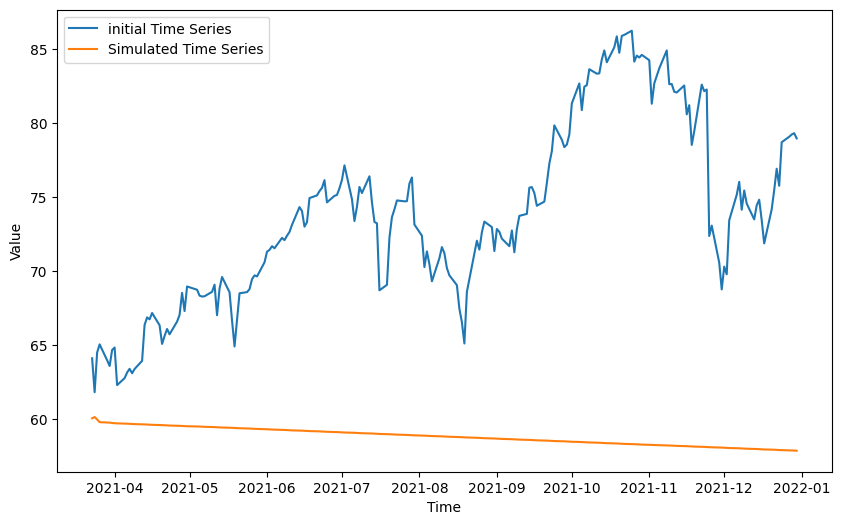

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='initial Time Series')
arima_res = model_ar1_fit.forecast(steps=data.shape[0] - train_size)
plt.plot(test.index, arima_res.values, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(arima_res.values, test)

14.871153354108024

### ML model

In [13]:
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import LinearRegression

In [14]:
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

def calculate_macd(series, short_period, long_period, signal_period):
    ema_short = calculate_ema(series, short_period)
    ema_long = calculate_ema(series, long_period)
    macd = ema_short - ema_long
    signal_line = calculate_ema(macd, signal_period)
    return macd, signal_line

def calculate_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def reconstruct_value(prev_value, logs, type_="diff"):
    if type_ == "diff":
        result = np.exp(logs) + prev_value
    else:
        result = np.exp(logs) * prev_value
    return result

def autoregressive(
    model, 
    out_start, 
    steps,
    categorical,
    numerical,
):
    results = list(out_start)
    for step in range(steps):
        cur_data = pd.DataFrame({"out": results})
        preprocessed = generate_features(cur_data)
        # print(preprocessed)
        X_test = preprocessed[categorical + numerical]

        predictions = model.predict(X_test.iloc[-1:])
        predictions = np.exp(predictions[0]) * results[-1]
        results.append(predictions)
    
    return results


#### minimum for feature generation
minima_length = 30
def generate_features(data):
    # Feature engineering
    data = data.copy()
    for lag in range(1, 30, 5):
        data[f'log_lag0_lag{lag}'] = np.log(data['out'] / data['out'].shift(lag))
    for ema_range in [5, 10, 20, 30]:
        data[f'ema_{ema_range}'] = calculate_ema(data['out'], ema_range)
    macd, signal = calculate_macd(data['out'], 12, 26, 9)
    data['macd'] = macd
    data['macd_signal'] = signal
    for rsi_range in [5, 10, 20, 30]:
        data[f'rsi_{rsi_range}'] = calculate_rsi(data['out'], rsi_range)
    data["prev_value"] = data["out"].shift(1)

    # Dropping rows with NaNs caused by the indicators
    return data.dropna()

def generate_target(data, step=1):
    data = data.copy()
    data["target"] = np.log(data["out"].shift(-step) / data["out"])
    return data.dropna()

preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

# Splitting the dataset again, now with new features
### данные вверх ногами, поэтому такая путаница
split_point = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:split_point]
test_data = preprocessed_data[split_point:]

# Defining new features and target
categorical = ["dir"]
categorical = []
numerical = preprocessed_data.columns.drop(["dir", "out", "target", "prev_value"]).tolist()
X_train, y_train = train_data[categorical + numerical], train_data['target']
X_test, y_test = test_data[categorical + numerical], test_data['target']

# Initialize and fit the CatBoostRegressor
model = CatBoostRegressor(verbose=False)
model.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=100,
    cat_features=categorical, 
    eval_set=(X_test, y_test), 
    verbose=True
)
# model = LinearRegression()
# model.fit(X_train, y_train)

# Predicting and evaluating again
predictions = model.predict(X_test)
mse = mean_squared_error(
    reconstruct_value(test_data["out"], y_test, type_=""), 
    reconstruct_value(test_data["out"], predictions, type_="")
)
print(f'Mean Squared Error with Feature Engineering: {mse}')


Learning rate set to 0.048933
0:	learn: 0.0308057	test: 0.0196683	best: 0.0196683 (0)	total: 50.1ms	remaining: 50.1s
1:	learn: 0.0305554	test: 0.0196748	best: 0.0196683 (0)	total: 50.9ms	remaining: 25.4s
2:	learn: 0.0303181	test: 0.0196857	best: 0.0196683 (0)	total: 51.5ms	remaining: 17.1s
3:	learn: 0.0301685	test: 0.0196851	best: 0.0196683 (0)	total: 52.1ms	remaining: 13s
4:	learn: 0.0299152	test: 0.0196920	best: 0.0196683 (0)	total: 52.8ms	remaining: 10.5s
5:	learn: 0.0296582	test: 0.0196911	best: 0.0196683 (0)	total: 53.5ms	remaining: 8.87s
6:	learn: 0.0294875	test: 0.0196972	best: 0.0196683 (0)	total: 54.3ms	remaining: 7.71s
7:	learn: 0.0292787	test: 0.0197029	best: 0.0196683 (0)	total: 55ms	remaining: 6.82s
8:	learn: 0.0291147	test: 0.0197053	best: 0.0196683 (0)	total: 55.6ms	remaining: 6.12s
9:	learn: 0.0289398	test: 0.0197244	best: 0.0196683 (0)	total: 56.5ms	remaining: 5.59s
10:	learn: 0.0287578	test: 0.0197202	best: 0.0196683 (0)	total: 58.2ms	remaining: 5.23s
11:	learn: 0.028

### вывод результатов

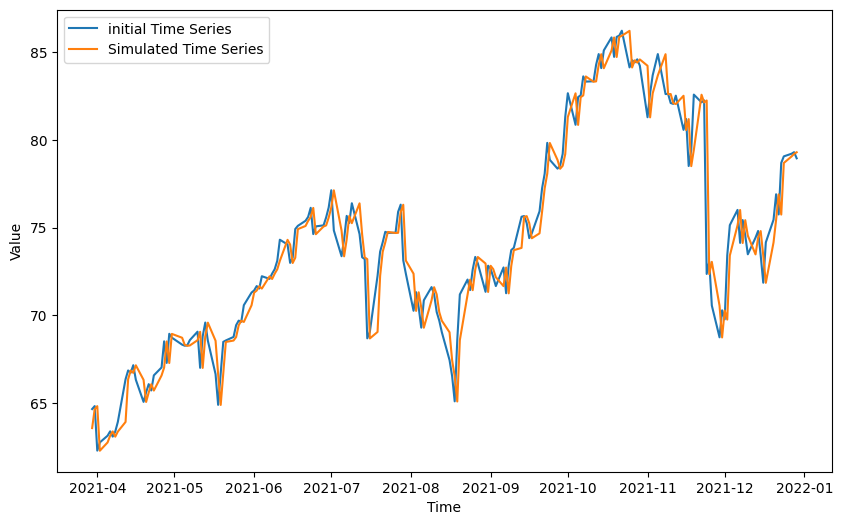

In [14]:
## с коррекцией

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, reconstruct_value(test_data["out"], y_test, type_=""), label='initial Time Series')
plt.plot(test_data.index, reconstruct_value(test_data["out"], predictions, type_=""), label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

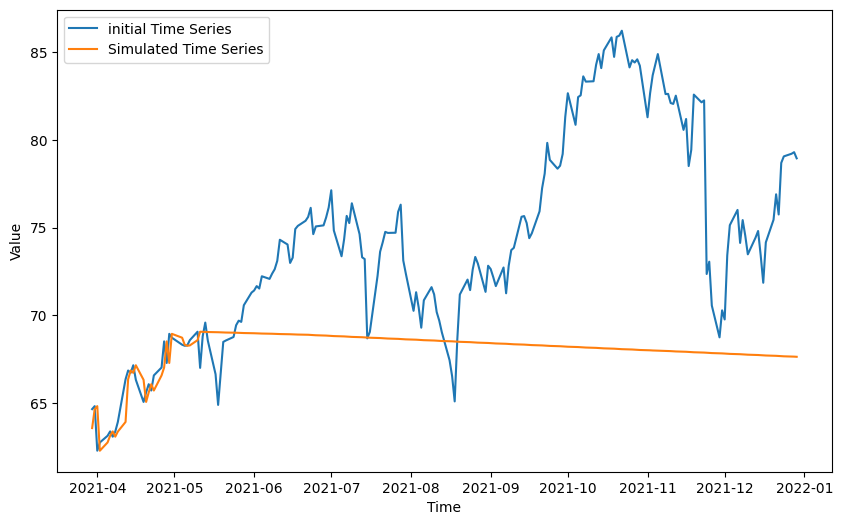

In [15]:
## В авторегрессии

result = autoregressive(
    model, 
    test_data.out.iloc[:minima_length], 
    steps = len(test_data) - minima_length,
    categorical=categorical,
    numerical=numerical,
)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, reconstruct_value(test_data["out"], y_test, type_=""), label='initial Time Series')
plt.plot(test_data.index, result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
mean_squared_error(
    reconstruct_value(test_data["out"], y_test, type_=""), 
    result
)

66.42632738587103

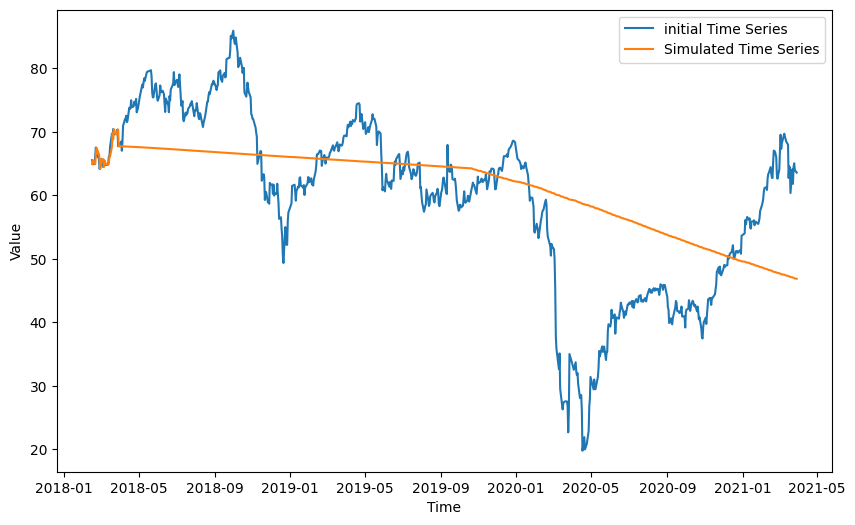

In [17]:
## В авторегрессии

result = autoregressive(
    model, 
    train_data["out"].iloc[:minima_length], 
    steps = len(train_data) - minima_length,
    categorical=categorical,
    numerical=numerical,
)

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, reconstruct_value(train_data["out"], y_train, type_=""), label='initial Time Series')
plt.plot(train_data.index, result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Выводы

Данных недостаточно для работы более менее хорошей мль модели. Однако статистические модели, вполне можно потроить

In [15]:
preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

categorical = ["dir"]
categorical = []
numerical = preprocessed_data.columns.drop(["dir", "out", "target", "prev_value"]).tolist()
preprocessed_data = preprocessed_data[categorical + numerical]

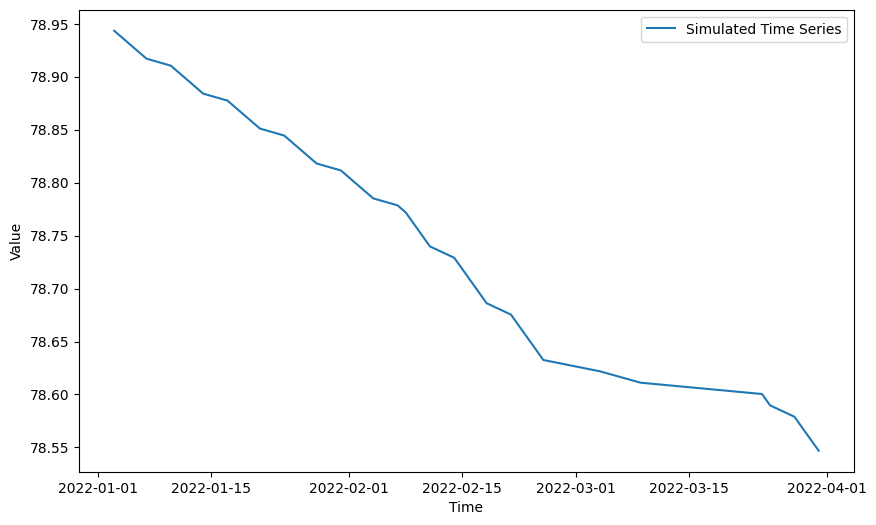

In [17]:
result = autoregressive(
    model, 
    data["out"].iloc[-minima_length:], 
    steps = len(result_df),
    categorical=categorical,
    numerical=numerical,
)
result = result[-len(result_df):]

plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
result_df["выход"] = result

### Теперь предскажем направление

In [21]:
#### minimum for feature generation
minima_length = 30
def generate_features(data):
    # Feature engineering
    data = data.copy()
    for lag in range(1, 30, 5):
        data[f'log_lag0_lag{lag}'] = np.log(data['out'] / data['out'].shift(lag))
    for ema_range in [5, 10, 20, 30]:
        data[f'ema_{ema_range}'] = calculate_ema(data['out'], ema_range)
    macd, signal = calculate_macd(data['out'], 12, 26, 9)
    data['macd'] = macd
    data['macd_signal'] = signal
    for rsi_range in [5, 10, 20, 30]:
        data[f'rsi_{rsi_range}'] = calculate_rsi(data['out'], rsi_range)
    data["prev_value"] = data["out"].shift(1)
    for lag in range(1, 30, 3):
        data[f'dir_lag{lag}'] = data['dir'].shift(lag)

    # Dropping rows with NaNs caused by the indicators
    return data.dropna()

def generate_target(data, step=1):
    data = data.copy()
    data["target_class"] = data["dir"].shift()
    return data.dropna()

def autoregressive(
    model, 
    model_class,
    out_start, 
    steps,
    categorical,
    numerical,
):
    results = list(out_start["out"])
    results_class = list(out_start["dir"])
    for step in range(steps):
        cur_data = pd.DataFrame({"out": results, "dir": results_class})
        preprocessed = generate_features(cur_data)
        # print(preprocessed)
        X_test = preprocessed[categorical + numerical]
        # print(X_test)

        predictions = model.predict(X_test.iloc[-1:].drop(columns=X_test.filter(like="dir").columns))
        predictions_class = model_class.predict(X_test.iloc[-1:])
        predictions = np.exp(predictions[0]) * results[-1]
        results.append(predictions)
        results_class.append(predictions_class[0])
    
    return results_class

preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

split_point = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:split_point]
test_data = preprocessed_data[split_point:]

# Defining new features and target
categorical = preprocessed_data.filter(like="dir").columns.tolist()
numerical = preprocessed_data.columns.drop(["out", "target_class", "prev_value"] + categorical).tolist()
X_train, y_train = train_data[categorical + numerical], train_data['target_class']
X_test, y_test = test_data[categorical + numerical], test_data['target_class']

# Initialize and fit the CatBoostRegressor
model_cat = CatBoostClassifier(verbose=False)
model_cat.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=100,
    cat_features=categorical, 
    eval_set=(X_test, y_test), 
    verbose=True
)
# model = LinearRegression()
# model.fit(X_train, y_train)

# Predicting and evaluating again
predictions = model_cat.predict(X_test)

label_to_idx = {
    "л": 1,
    "ш": 0,
}
mse = f1_score(
    y_test.map(label_to_idx),
    list(map(lambda x: label_to_idx[x], predictions))
)
print(f'Mean Squared Error with Feature Engineering: {mse}')

Learning rate set to 0.029765
0:	learn: 0.6142265	test: 0.6129286	best: 0.6129286 (0)	total: 4.66ms	remaining: 4.66s
1:	learn: 0.5549217	test: 0.5521859	best: 0.5521859 (1)	total: 5.88ms	remaining: 2.93s
2:	learn: 0.5010252	test: 0.4931612	best: 0.4931612 (2)	total: 6.85ms	remaining: 2.28s
3:	learn: 0.4567702	test: 0.4526036	best: 0.4526036 (3)	total: 8ms	remaining: 1.99s
4:	learn: 0.4113636	test: 0.4078226	best: 0.4078226 (4)	total: 10.4ms	remaining: 2.06s
5:	learn: 0.3584424	test: 0.3560707	best: 0.3560707 (5)	total: 11.4ms	remaining: 1.89s
6:	learn: 0.3308279	test: 0.3290655	best: 0.3290655 (6)	total: 12.8ms	remaining: 1.82s
7:	learn: 0.2993859	test: 0.2967655	best: 0.2967655 (7)	total: 14ms	remaining: 1.74s
8:	learn: 0.2745385	test: 0.2722602	best: 0.2722602 (8)	total: 15.4ms	remaining: 1.69s
9:	learn: 0.2489010	test: 0.2457108	best: 0.2457108 (9)	total: 17ms	remaining: 1.68s
10:	learn: 0.2262701	test: 0.2270961	best: 0.2270961 (10)	total: 18.2ms	remaining: 1.64s
11:	learn: 0.20424

In [22]:
result = autoregressive(
    model, 
    model_cat,
    data.iloc[-minima_length:], 
    steps = len(result_df),
    categorical=categorical,
    numerical=numerical,
)
result = result[-len(result_df):]
result

['ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш',
 'ш']

In [23]:
result_df["направление"] = result
result_df["направление"] = result_df["направление"].map(label_to_idx)

In [24]:
import json
data1 = result_df["выход"].tolist()
data2 = result_df["направление"].tolist()
with open('forecast_value.json', 'w') as file:
    json.dump(data1, file)
with open('forecast_class.json', 'w') as file:
    json.dump(data2, file)